In [12]:
from data import generate_dataset, mse, ReLU, dReLU, sigmoid, dsigmoid, leaky_ReLU, dleaky_ReLU
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

n = 1000

x, y, y_noisy = generate_dataset(n=n, noise_std=0.5, random_state=1)

In [4]:
def sgd_adam_reg(X_train, y_train, X_test, y_test,
             activation, dactivation,
             layers=[1,10,1],
             eta=0.01, num_steps=1000,
             beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32, seed=0,
             lam=0.0, penalty=None):     # <------ new
    """
    penalty = None / "L2" / "L1"
    lam     = regularization strength
    """

    rng = np.random.default_rng(seed)
    n, d = X_train.shape
    # --- initialize weights ---
    W, b = [], []
    for i in range(len(layers)-1):
        W.append(rng.normal(0, 1/np.sqrt(layers[i]), (layers[i], layers[i+1])))
        b.append(np.zeros((1, layers[i+1])))
    # --- initialize Adam params ---
    mW = [np.zeros_like(w) for w in W]
    vW = [np.zeros_like(w) for w in W]
    mb = [np.zeros_like(bb) for bb in b]
    vb = [np.zeros_like(bb) for bb in b]

    mse_train, mse_test = [], []
    
    for t in range(1, num_steps+1):
        idx = rng.choice(n, batch_size, replace=False)
        Xb, yb = X_train[idx], y_train[idx]
        
        # --- forward ---
        A = [Xb]
        for i in range(len(W)-1):
            Z = A[-1] @ W[i] + b[i]
            A.append(activation(Z))
        ZL = A[-1] @ W[-1] + b[-1]   # linear output
        yhat = ZL

        # --- backward ---
        dZ = 2.0*(yhat - yb)/batch_size
        dW, db = [None]*len(W), [None]*len(W)
        dW[-1] = A[-1].T @ dZ
        db[-1] = np.sum(dZ, axis=0, keepdims=True)
        dA = dZ @ W[-1].T
        for i in range(len(W)-2, -1, -1):
            dZ = dA * dactivation(A[i+1])
            dW[i] = A[i].T @ dZ
            db[i] = np.sum(dZ, axis=0, keepdims=True)
            if i > 0:
                dA = dZ @ W[i].T

        # --- regularization added to weight gradients ---
        if lam > 0 and penalty is not None:
            for i in range(len(W)):
                if penalty == "L2":
                    dW[i] += lam * W[i]
                elif penalty == "L1":
                    dW[i] += lam * np.sign(W[i])

        # --- Adam update ---
        for i in range(len(W)):
            mW[i] = beta1*mW[i] + (1-beta1)*dW[i]
            vW[i] = beta2*vW[i] + (1-beta2)*(dW[i]**2)
            mb[i] = beta1*mb[i] + (1-beta1)*db[i]
            vb[i] = beta2*vb[i] + (1-beta2)*(db[i]**2)
            mW_hat = mW[i] / (1 - beta1**t)
            vW_hat = vW[i] / (1 - beta2**t)
            mb_hat = mb[i] / (1 - beta1**t)
            vb_hat = vb[i] / (1 - beta2**t)
            W[i] -= eta * mW_hat / (np.sqrt(vW_hat) + eps)
            b[i] -= eta * mb_hat / (np.sqrt(vb_hat) + eps)

        def forward(X):
            A = X
            for i in range(len(W)-1):
                A = activation(A @ W[i] + b[i])
            return A @ W[-1] + b[-1]

        mse_train.append(mse(y_train, forward(X_train)))
        mse_test.append(mse(y_test, forward(X_test)))

    return W, b, mse_train, mse_test


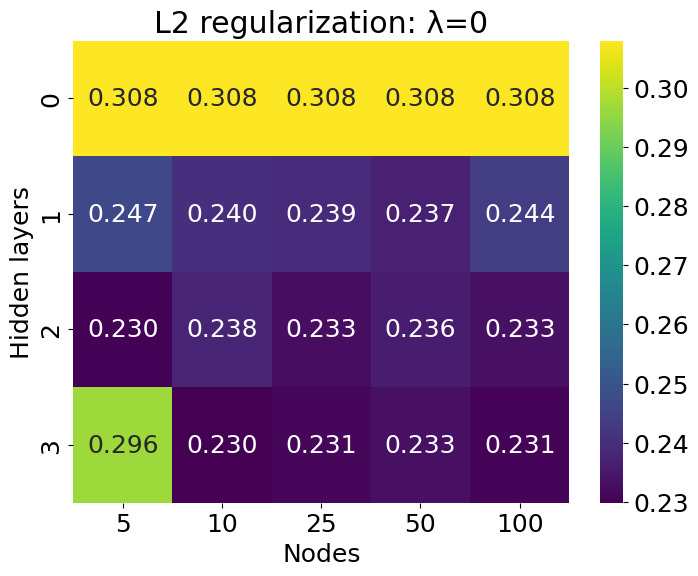

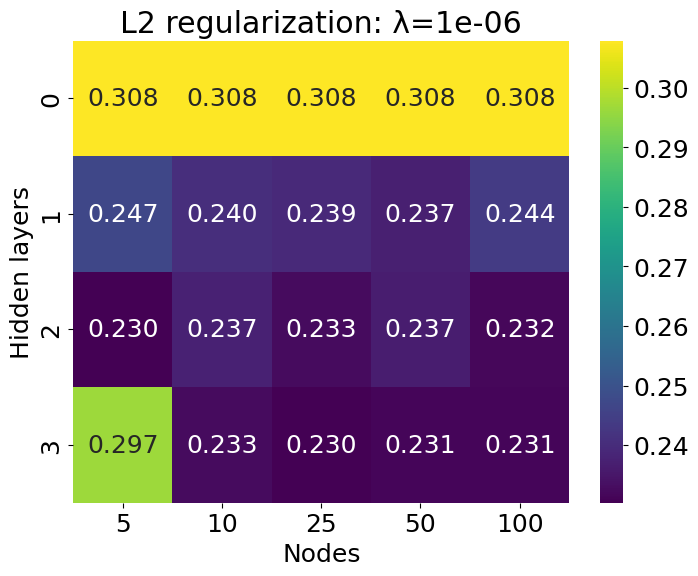

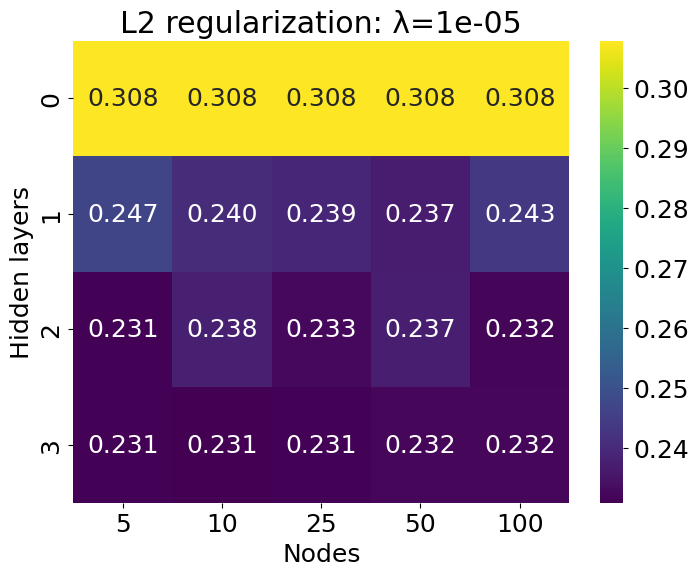

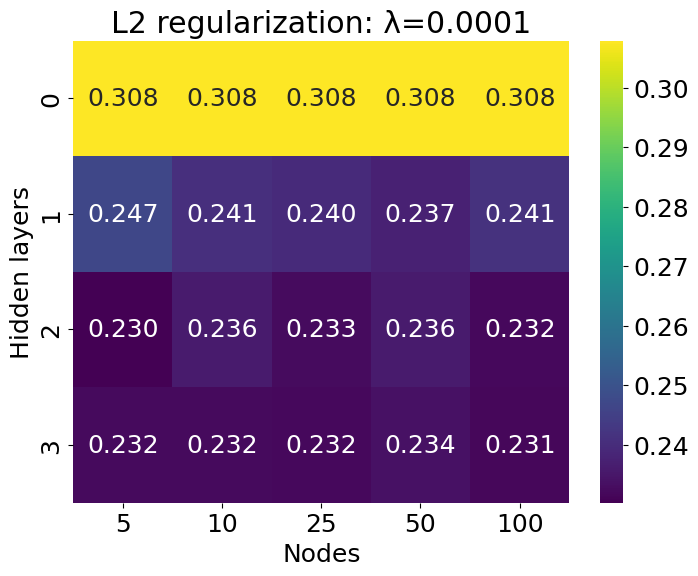

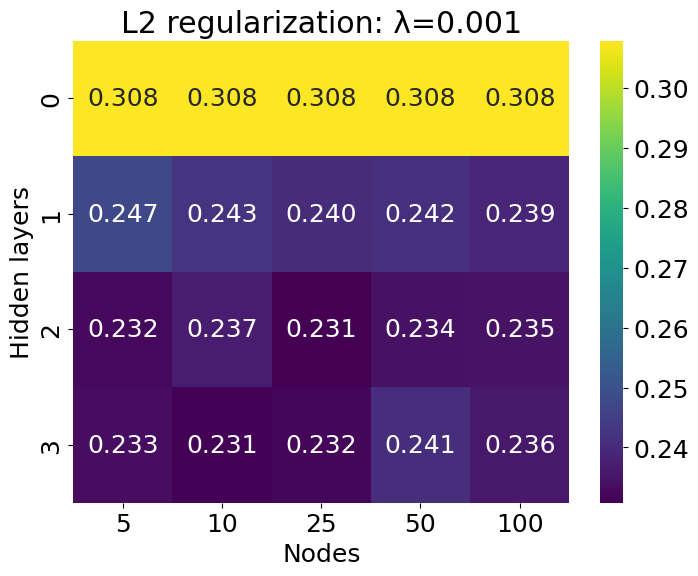

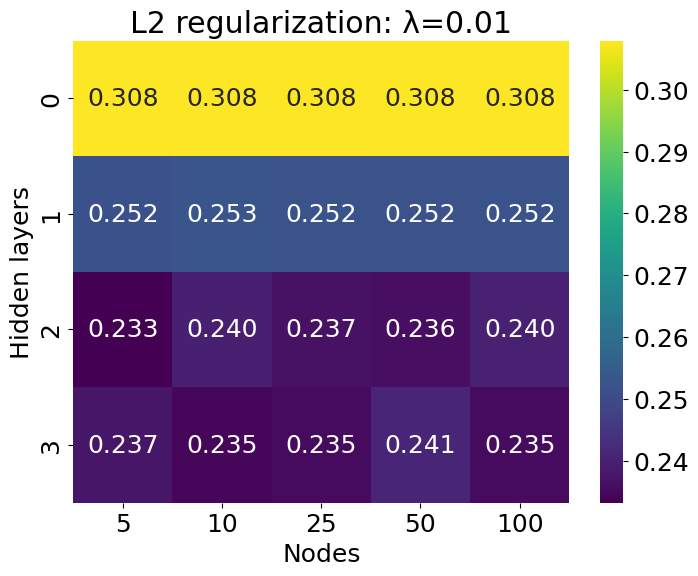

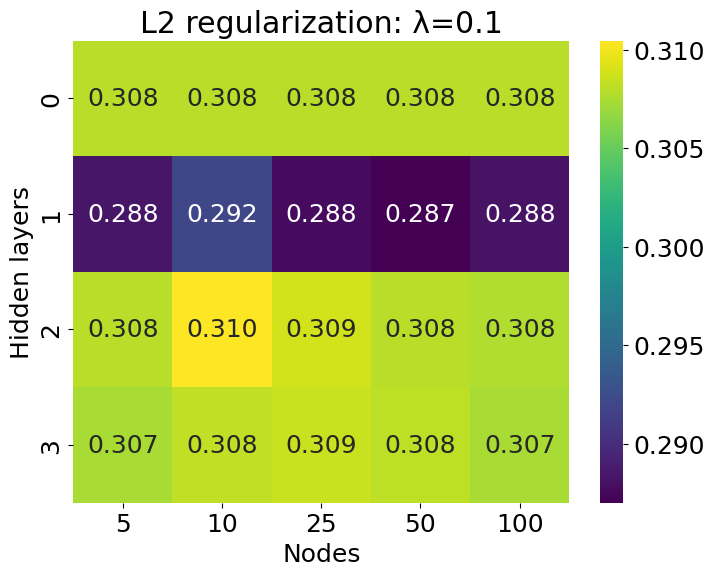

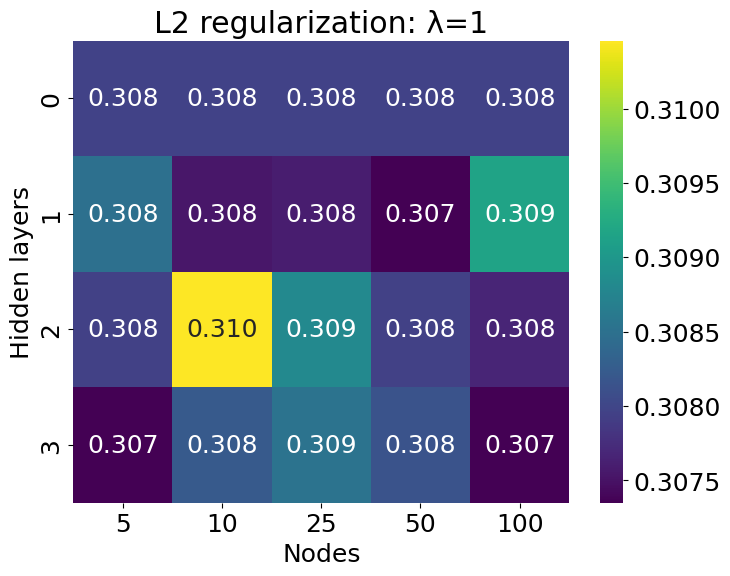

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y_noisy, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


hidden_layers_list = [0, 1, 2, 3]
nodes_list = [5, 10, 25, 50, 100]

lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  ReLU, dReLU,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L2",
                                  seed=1)

            results[i,j] = te[-1]

    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L2 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()

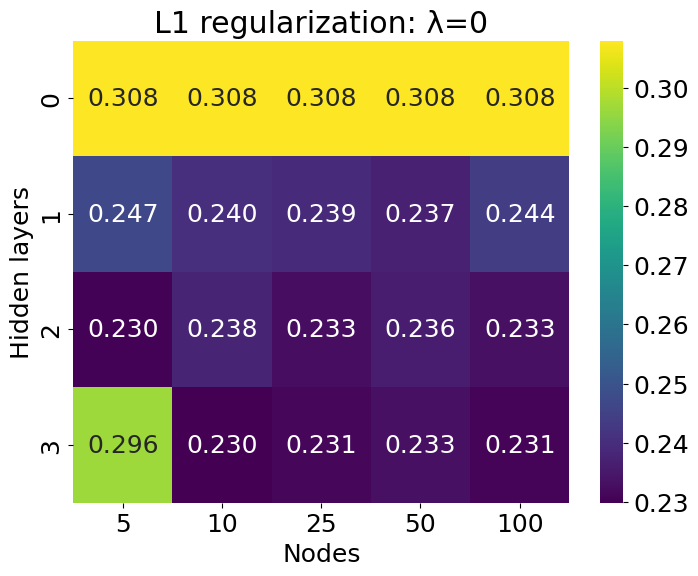

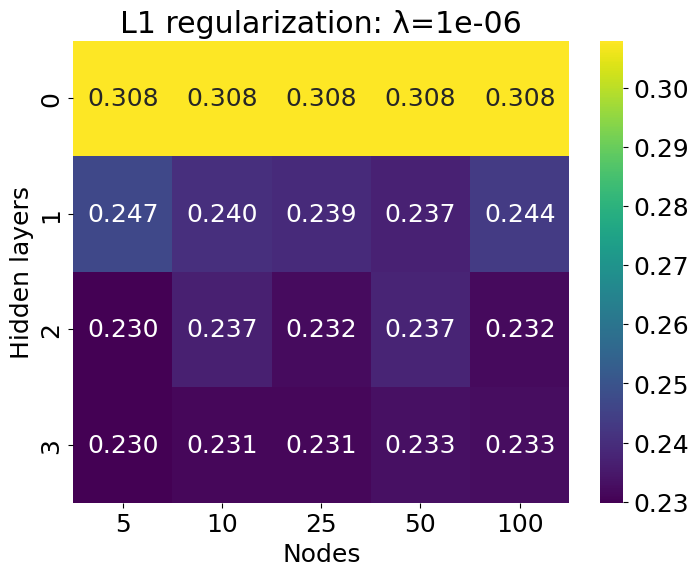

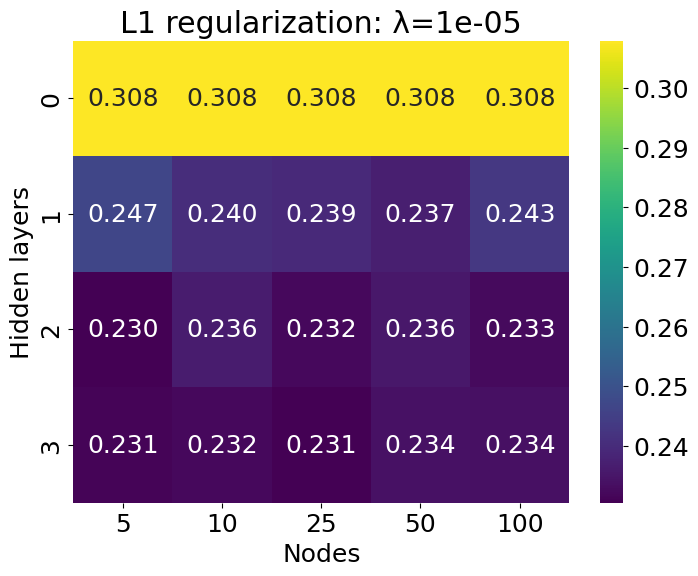

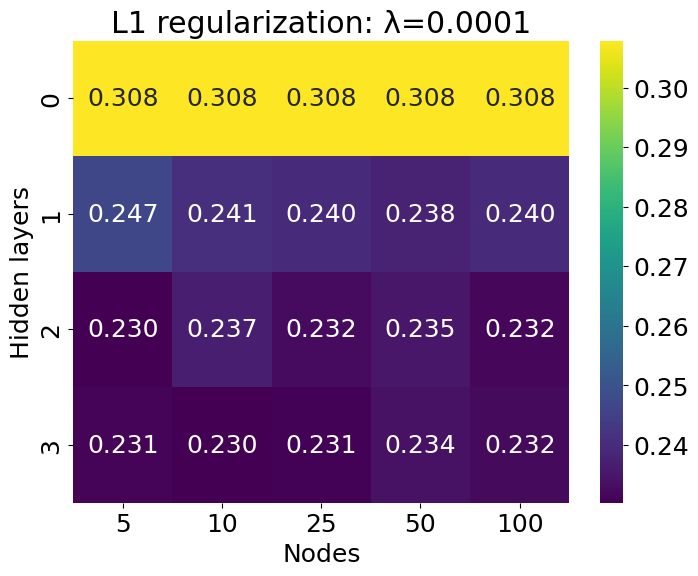

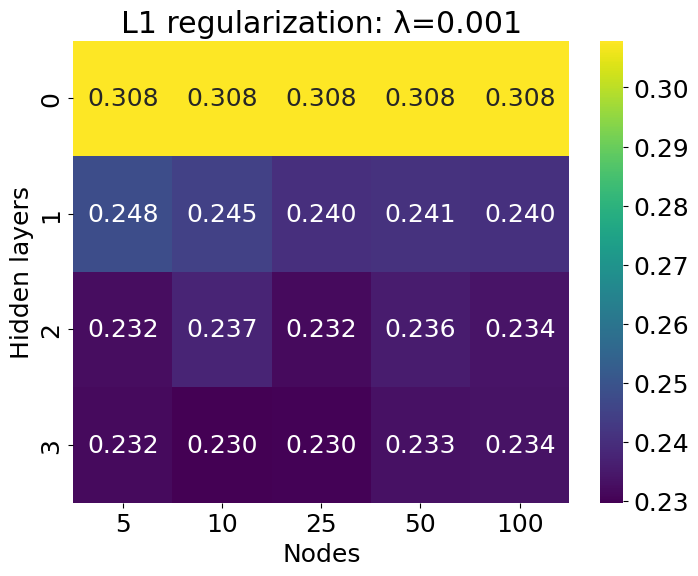

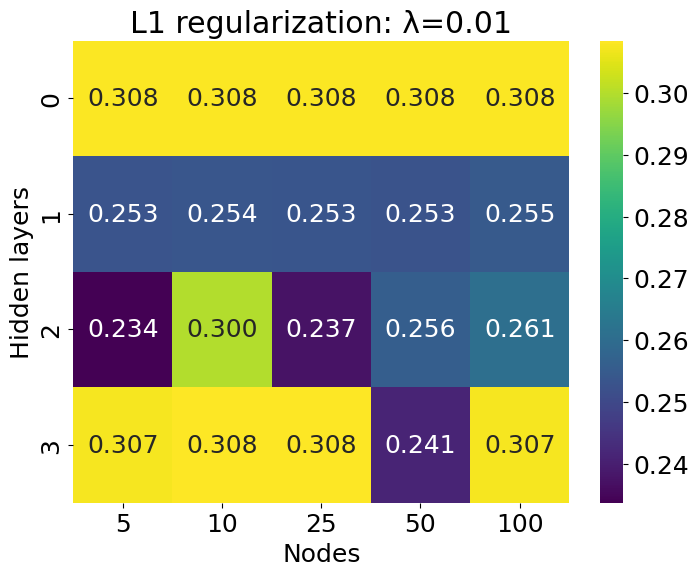

In [6]:
lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  ReLU, dReLU,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L1",
                                  seed=1)

            results[i,j] = te[-1]

    # plot heatmap for this lamb
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L1 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()

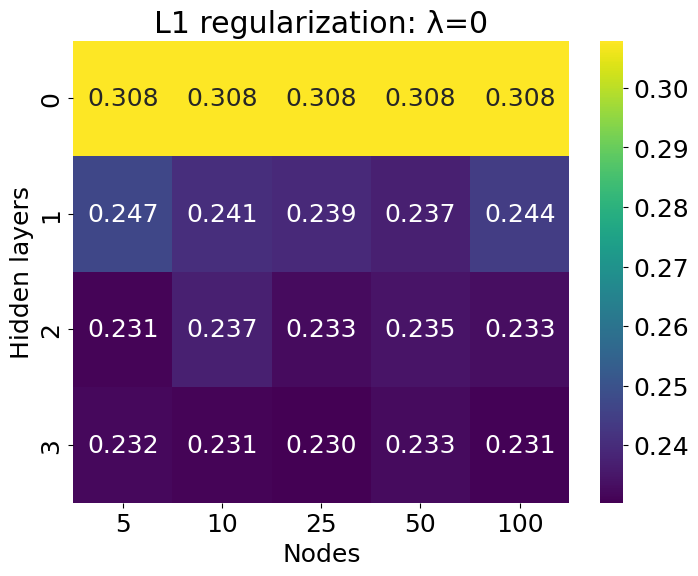

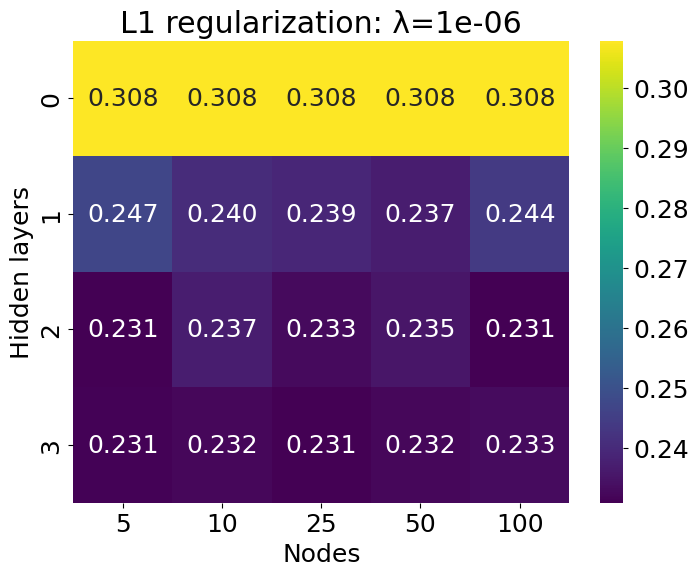

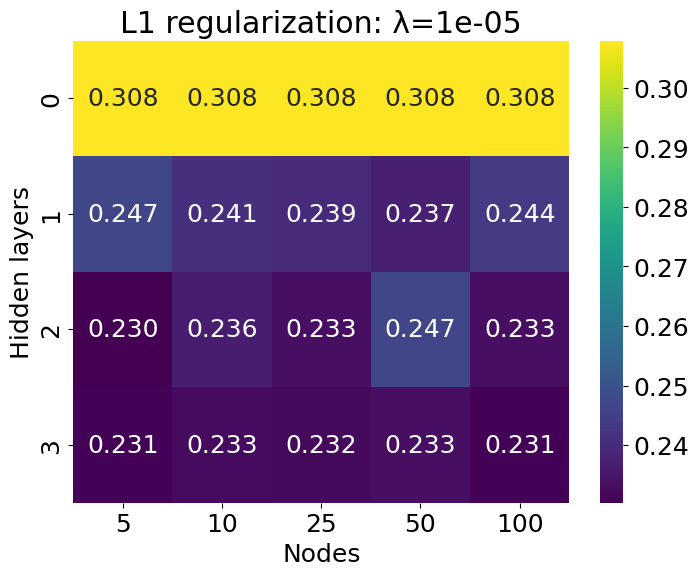

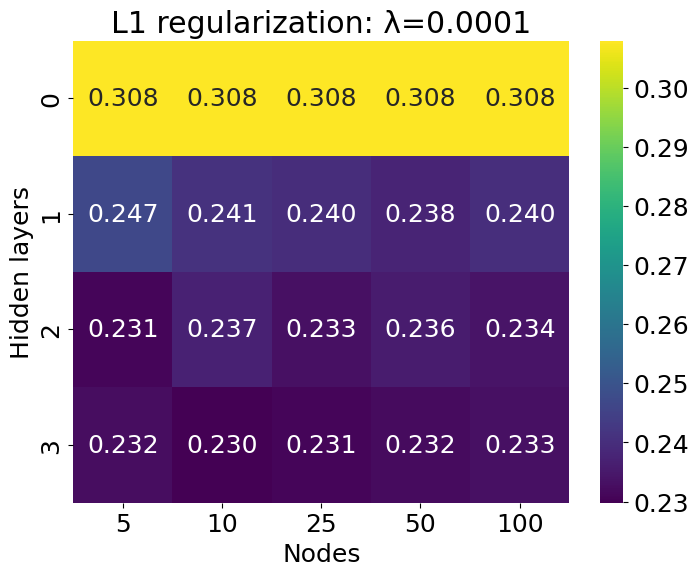

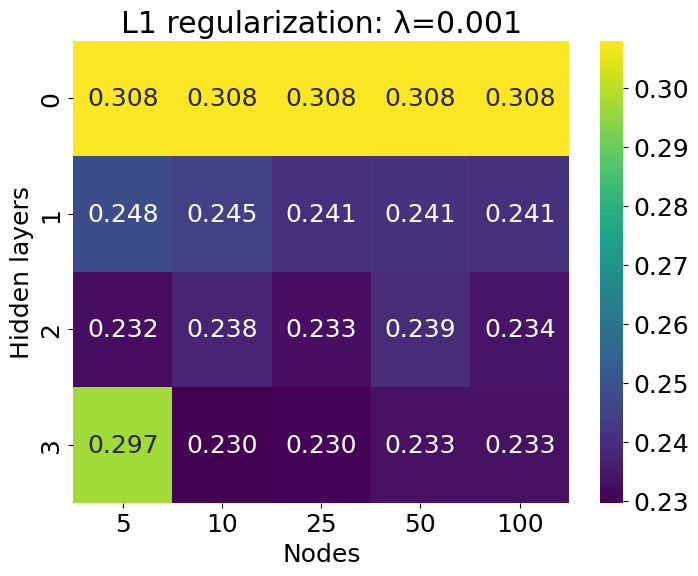

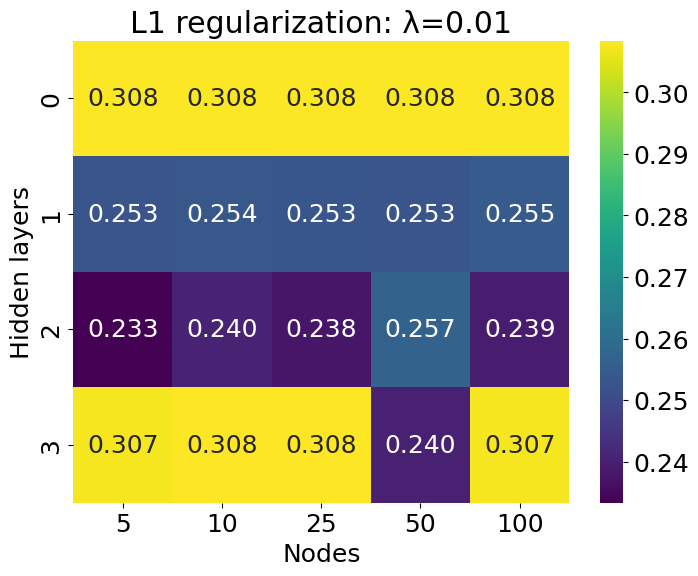

In [7]:
lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  leaky_ReLU, dleaky_ReLU,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L1",
                                  seed=1)

            results[i,j] = te[-1]

    # plot heatmap for this lambda
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L1 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()

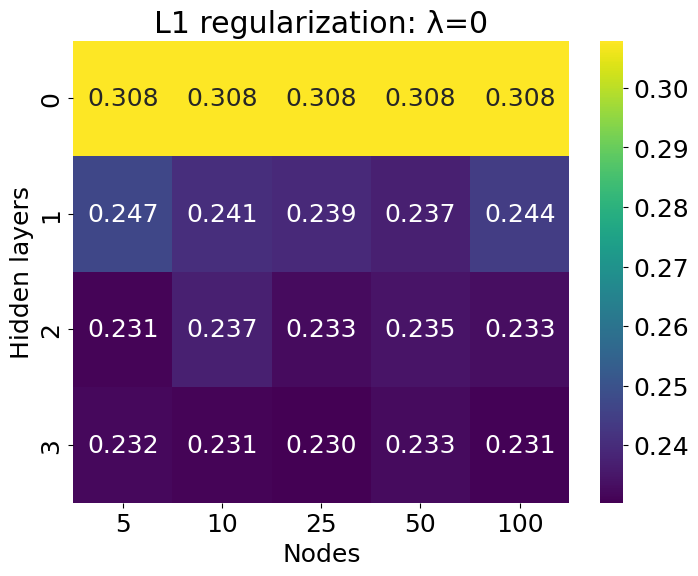

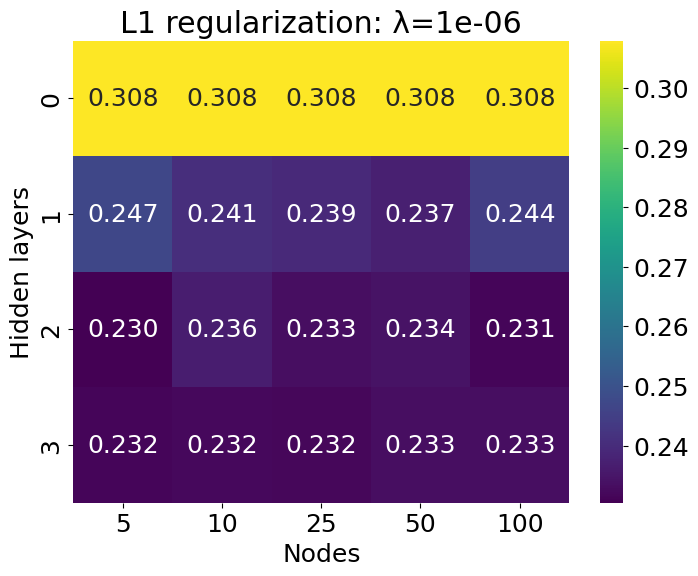

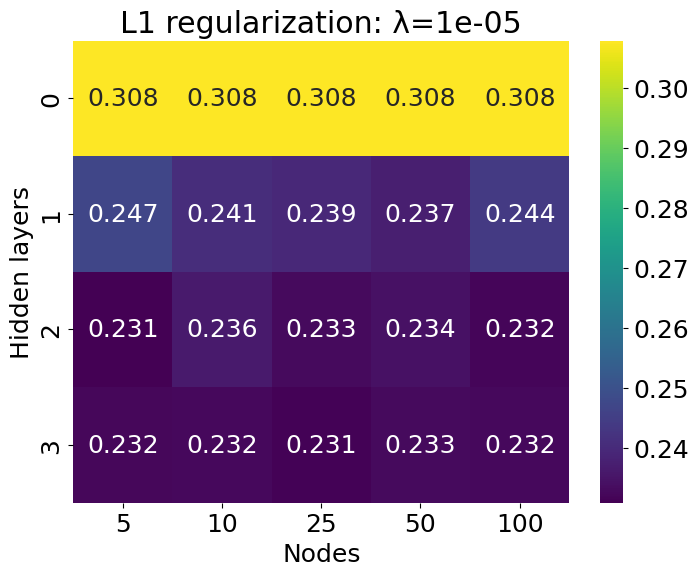

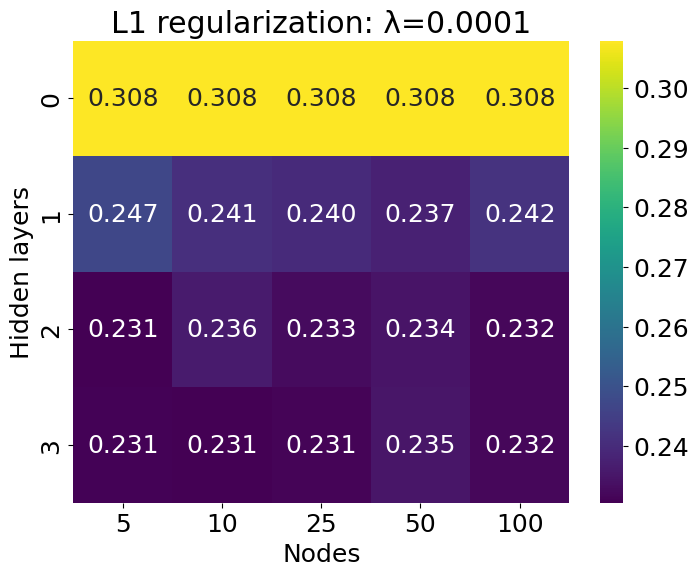

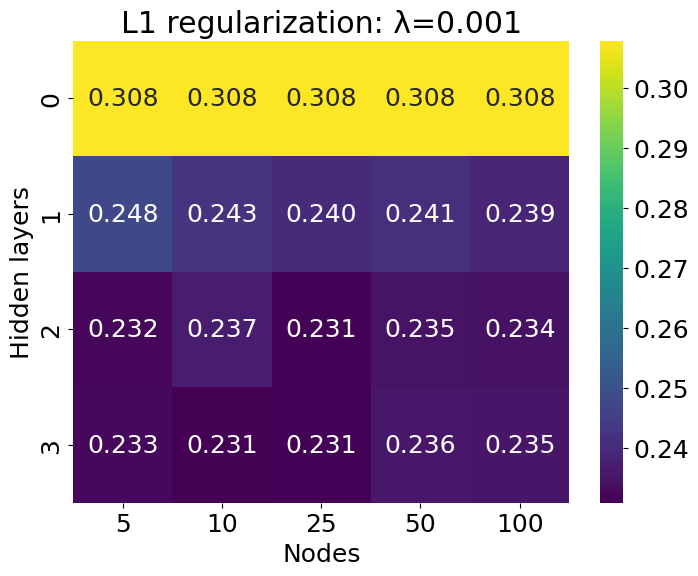

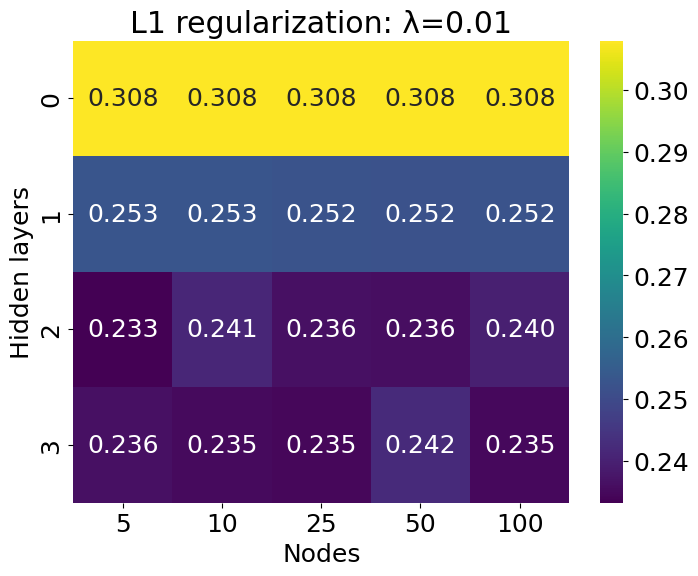

In [8]:
lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  leaky_ReLU, dleaky_ReLU,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L2",
                                  seed=1)

            results[i,j] = te[-1]

    # plot heatmap for this lambda
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L1 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()

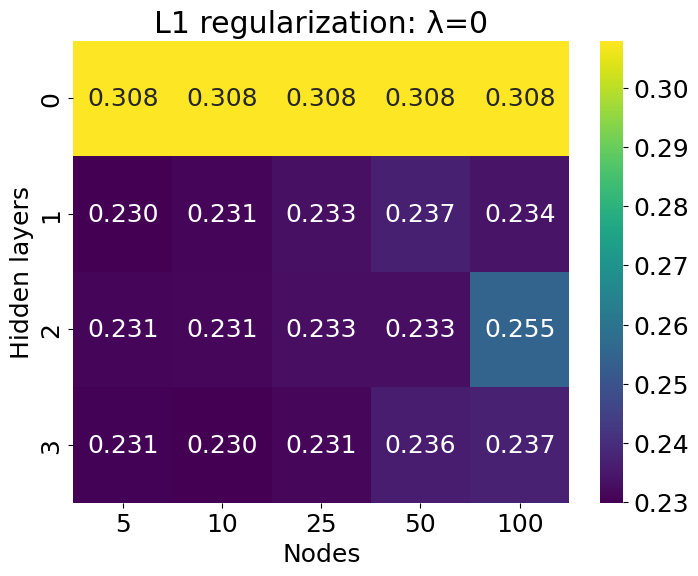

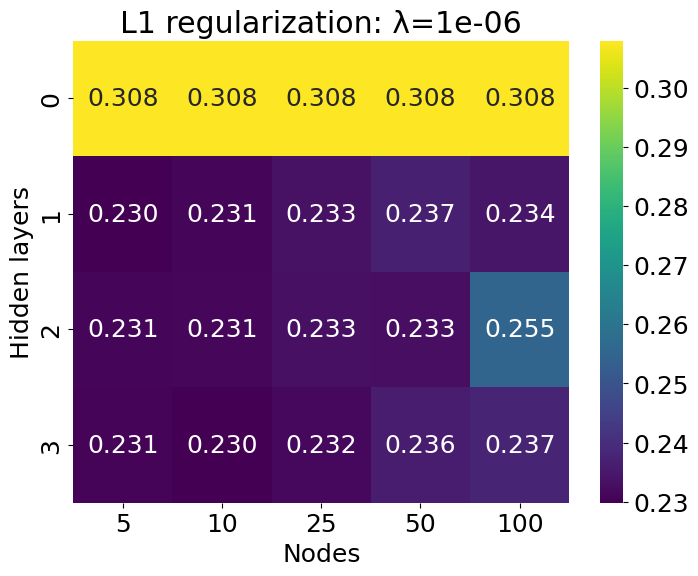

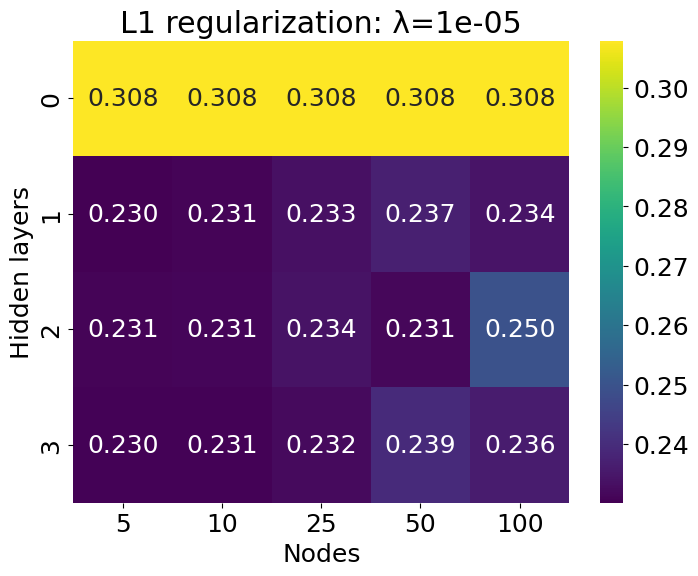

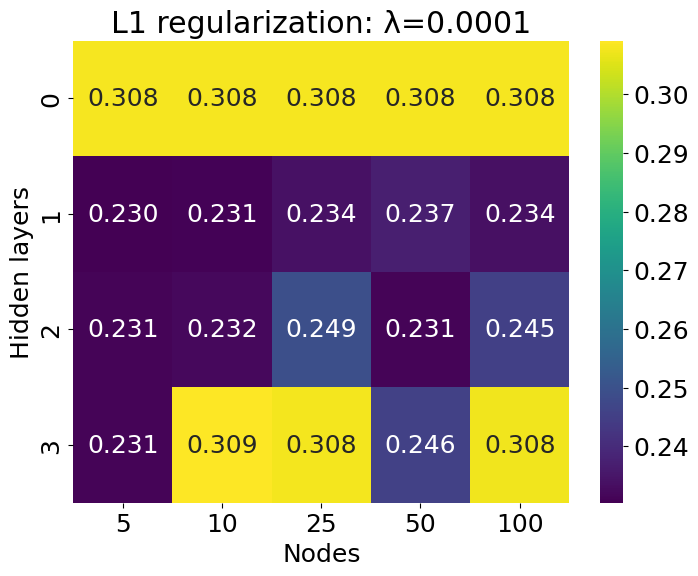

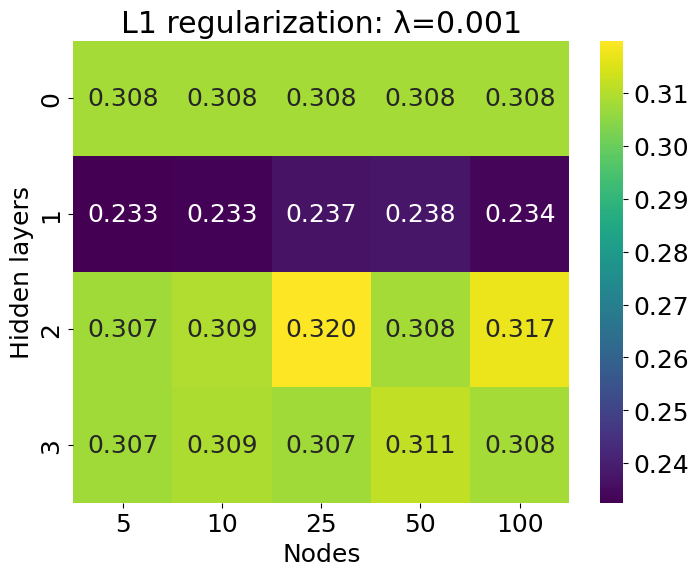

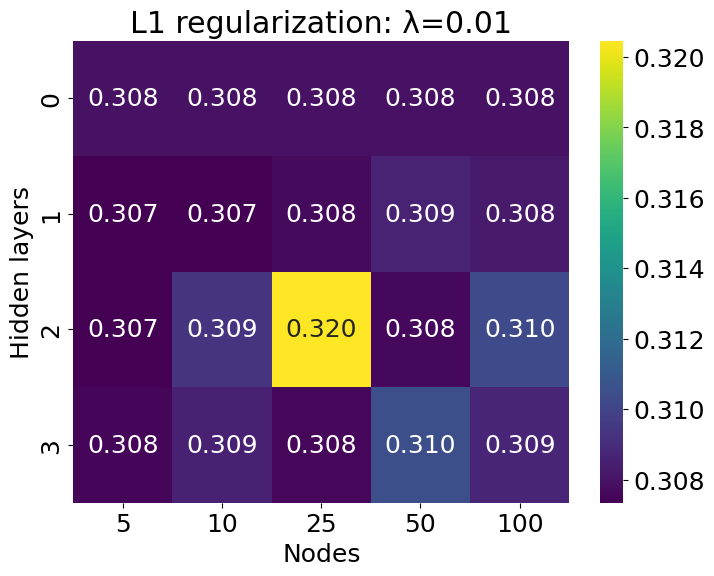

In [9]:
lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  sigmoid, dsigmoid,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L1",
                                  seed=1)

            results[i,j] = te[-1]

    # plot heatmap for this lambda
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L1 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()

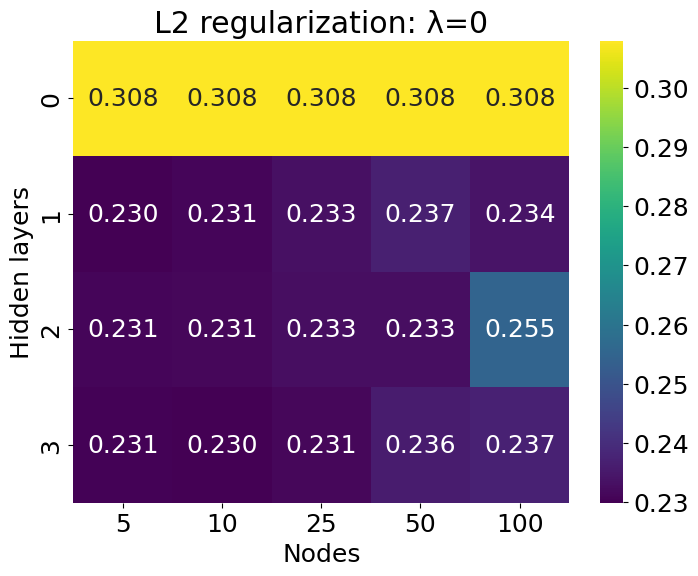

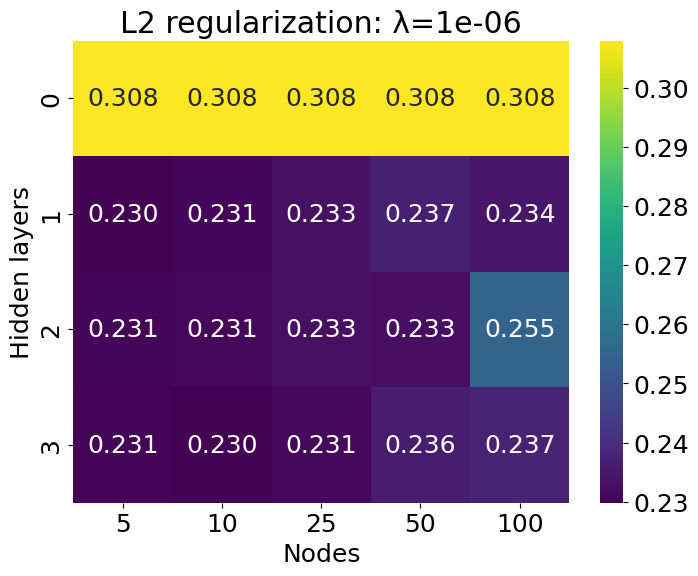

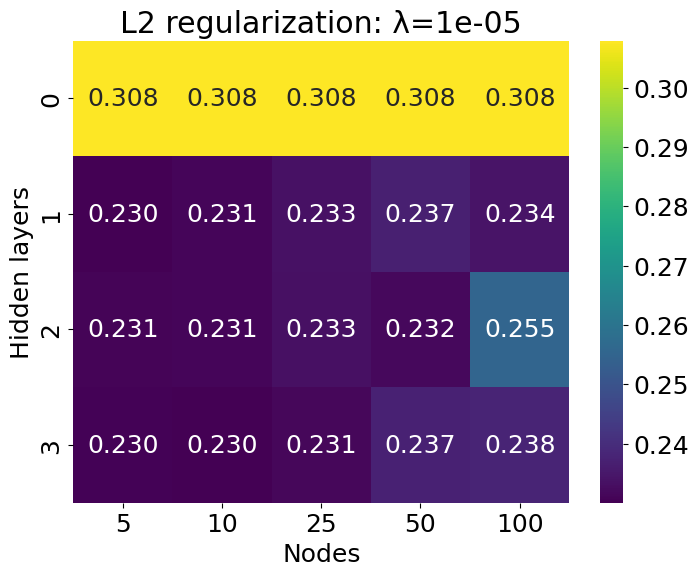

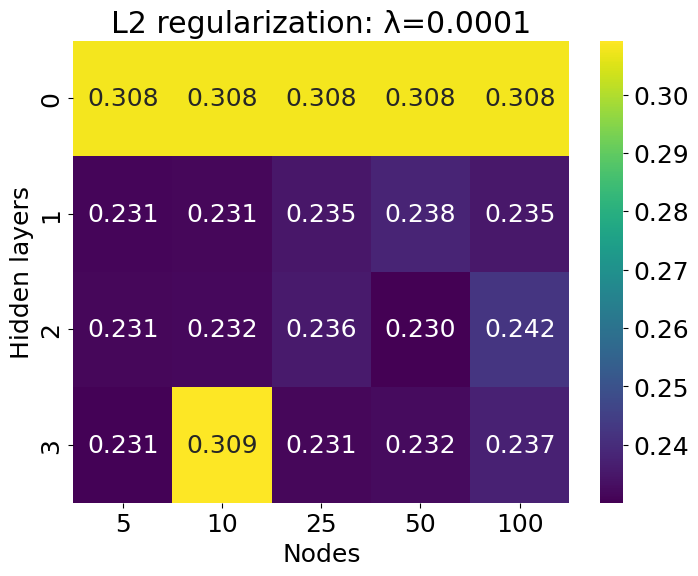

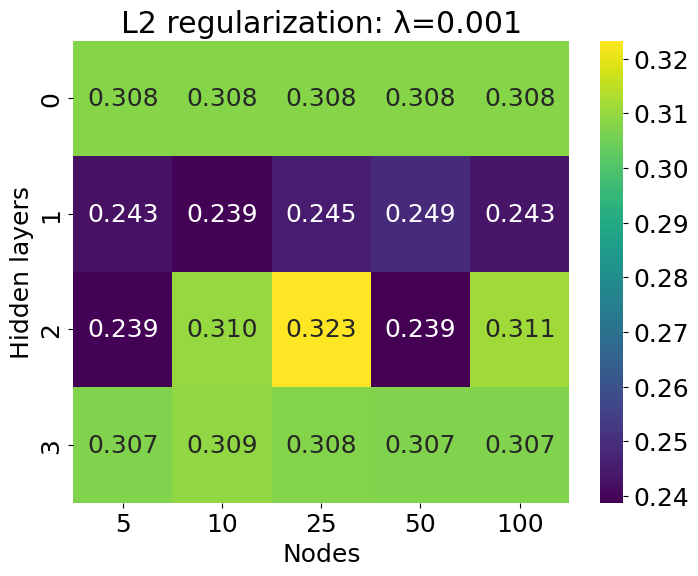

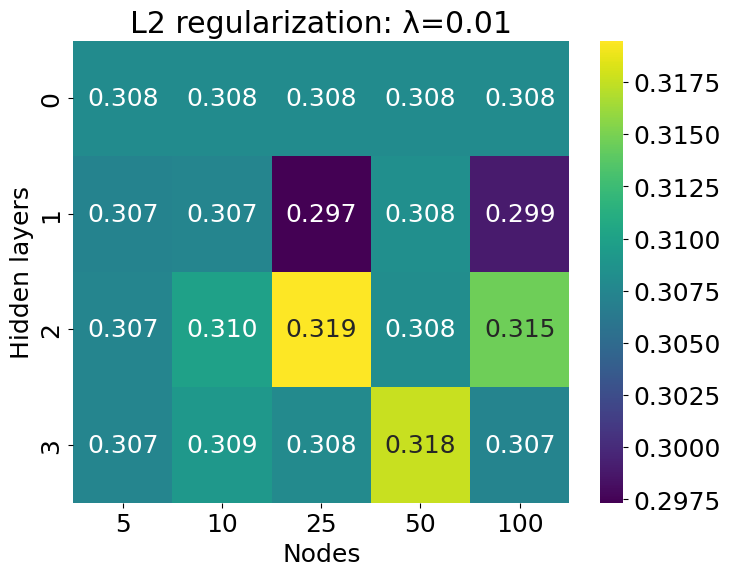

In [10]:
lams = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = np.zeros((len(lams), len(nodes_list)))

for L in lams:
    results = np.zeros((len(hidden_layers_list), len(nodes_list)))

    for i, n_layers in enumerate(hidden_layers_list):
        for j, n_nodes in enumerate(nodes_list):
            if n_layers == 0:
                layers = [1,1]
            else:
                layers = [1] + [n_nodes]*n_layers + [1]

            W,b,tr,te = sgd_adam_reg(x_train_scaled, y_train, x_test_scaled, y_test,
                                  sigmoid, dsigmoid,
                                  layers=layers,
                                  eta=0.01, num_steps=1500,
                                  lam=L, penalty="L2",
                                  seed=1)

            results[i,j] = te[-1]

    # plot heatmap for this lambda
    plt.figure(figsize=(8,6))
    sns.heatmap(results, annot=True, fmt=".3f", cmap="viridis",
                xticklabels=nodes_list,
                yticklabels=hidden_layers_list)
    plt.title(f"L2 regularization: λ={L}")
    plt.xlabel("Nodes")
    plt.ylabel("Hidden layers")
    plt.show()